## Support Vector Regression

In [1]:
import pandas as pd
import numpy as np
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty, ElementFraction, Meredig, Stoichiometry
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score,KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data Processing

In [2]:
descriptors = pd.read_csv('./descriptors.csv', delimiter = ';')
descriptors = descriptors.drop(descriptors.columns[0],axis=1)
descriptors 

,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,52.0,29.0,35.333332,11.111111,23.0,46.0,90.0,44.0,70.000000,16.000000,...,0.0,0.0,0.0,0.0,64.0,229.0,165.0,148.33333,56.222220,64.0
1,31.0,16.0,23.000000,8.000000,15.0,74.0,83.0,9.0,78.500000,4.500000,...,0.0,0.0,0.0,0.0,2.0,64.0,62.0,33.00000,31.000000,2.0
2,31.0,16.0,23.000000,8.000000,15.0,74.0,83.0,9.0,78.500000,4.500000,...,0.0,0.0,0.0,0.0,2.0,64.0,62.0,33.00000,31.000000,2.0
3,33.0,2.0,32.000000,1.000000,31.0,74.0,84.0,10.0,79.000000,5.000000,...,0.0,0.0,0.0,0.0,64.0,166.0,102.0,115.00000,51.000000,64.0
4,31.0,16.0,23.000000,8.000000,15.0,74.0,83.0,9.0,78.500000,4.500000,...,0.0,0.0,0.0,0.0,2.0,64.0,62.0,33.00000,31.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526,31.0,16.0,23.000000,8.000000,15.0,74.0,83.0,9.0,78.500000,4.500000,...,0.0,0.0,0.0,0.0,2.0,64.0,62.0,33.00000,31.000000,2.0
2527,56.0,25.0,40.666668,10.222222,31.0,9.0,95.0,86.0,59.333332,33.555557,...,0.0,0.0,0.0,0.0,64.0,229.0,165.0,119.00000,73.333336,64.0
2528,31.0,16.0,23.000000,8.000000,15.0,74.0,83.0,9.0,78.500000,4.500000,...,0.0,0.0,0.0,0.0,2.0,64.0,62.0,33.00000,31.000000,2.0
2529,33.0,2.0,32.000000,1.000000,31.0,74.0,84.0,10.0,79.000000,5.000000,...,0.0,0.0,0.0,0.0,64.0,166.0,102.0,115.00000,51.000000,64.0


In [3]:
dataset = pd.read_csv('dataset.csv')
band_gaps = dataset["band_gap_vals"]
band_gaps

0       0.088699
1       1.447379
2       1.496388
3       0.544622
4       1.440079
          ...   
2526    1.653516
2527    0.000000
2528    1.232222
2529    0.302066
2530    1.231642
Name: band_gap_vals, Length: 2531, dtype: float64

### Build the models

In [4]:
# set the X and y training data

X = descriptors
y = band_gaps

In [5]:
# Generate train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Scaling the features 
scale = StandardScaler()
X_train_sd = scale.fit_transform(X_train)
X_test_sd = scale.transform(X_test)

In [6]:
# define and train on the model
model = SVR(C=1.0, epsilon=0.2)
model.fit(X_train, y_train)

SVR(epsilon=0.2)

### Best Hyperparameters Tuning using GridSearch

In [7]:
clf_svr = SVR()
svr_hyperparams = {'C': [0.1, 1, 10], 'epsilon': [0.02, 0.2, 2]}
grid_search = GridSearchCV(model, svr_hyperparams, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 10, 'epsilon': 0.02}
Best score:  0.7536292292245517


### Results

In [8]:
model_bestpara = SVR(C=10, epsilon=0.02)
model_bestpara.fit(X_train, y_train)

SVR(C=10, epsilon=0.02)

In [9]:
model_bestpara.score(X_test, y_test) # get the coefficient of determination of the prediction.

0.6994252444466882

In [10]:
train_preds = model_bestpara.predict(X_train)
test_preds = model_bestpara.predict(X_test)

In [11]:
MAE = mean_absolute_error(test_preds,y_test)
MSE = mean_squared_error(test_preds,y_test)
RMSE = np.sqrt(MSE)
print(MAE)
print(MSE)
print(RMSE)

0.20493282961974196
0.14095153116533277
0.3754351224450541


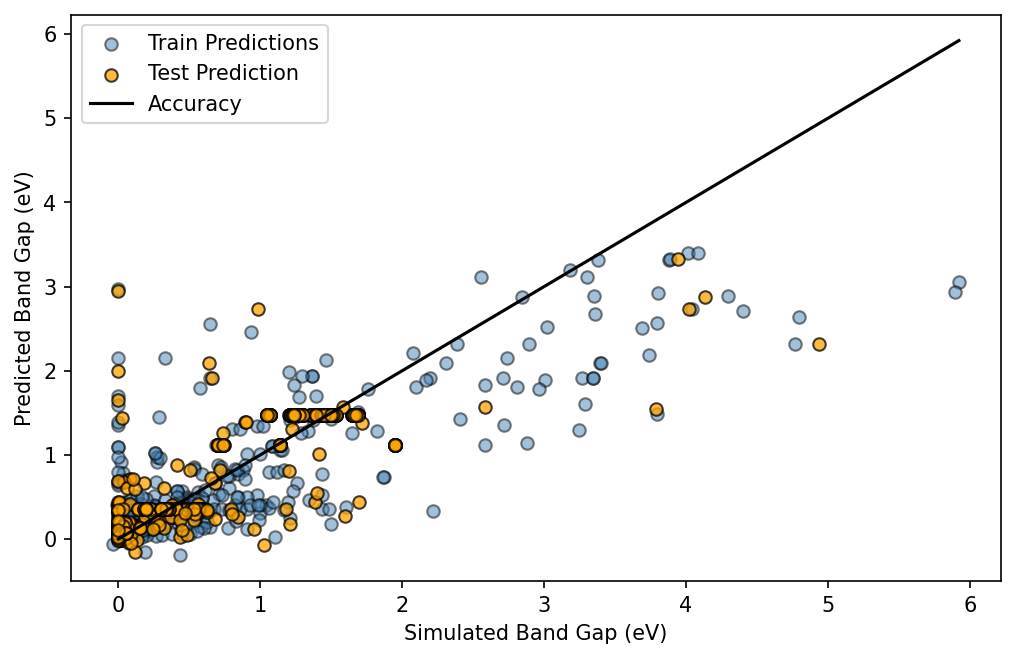

In [12]:
fig, ax = plt.subplots(figsize=[8, 5], dpi=150)
acc = np.linspace(0, np.max(np.concatenate([y_train, train_preds, y_test, test_preds])), 1000)
ax.scatter(y_train, train_preds, color='steelblue', edgecolor='k', alpha=0.5, label='Train Predictions')
ax.scatter(y_test, test_preds, color='orange', edgecolor='k', alpha=0.75, label='Test Prediction')
ax.plot(acc, acc, label='Accuracy', color='black')
ax.set_xlabel('Simulated Band Gap (eV)')
ax.set_ylabel('Predicted Band Gap (eV)')
plt.legend()

### Cross-validation

In [13]:
scores = cross_val_score(model_bestpara, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.73 accuracy with a standard deviation of 0.03


## The top descriptors from lasso regression

In [9]:
X_top = descriptors[['MagpieData mode Electronegativity','MagpieData range Electronegativity','MagpieData mean NfValence',"MagpieData mode MendeleevNumber","MagpieData range NsValence"]] 

# Scaling the features 
scale = StandardScaler()
X_top = scale.fit_transform(X_top)
X_top

array([[-0.50468789, -0.23460369, -0.2348501 , -1.39145975, -0.33039029],
       [-0.11642448, -0.43090245, -0.2348501 ,  0.22200246, -0.33039029],
       [-0.11642448, -0.43090245, -0.2348501 ,  0.22200246, -0.33039029],
       ...,
       [-0.11642448, -0.43090245, -0.2348501 ,  0.22200246, -0.33039029],
       [-0.11642448, -0.45271343, -0.2348501 ,  0.22200246, -0.33039029],
       [-0.11642448, -0.43090245, -0.2348501 ,  0.22200246, -0.33039029]])

In [10]:
# Generate train and test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X_top, y, test_size=0.2, random_state=32)

# GridSearcch 
clf_top = SVR()
svr_hyperparams = {'C': [0.1, 1, 10], 'epsilon': [0.02, 0.2, 2]}
grid_search = GridSearchCV(clf_top, svr_hyperparams, cv=5, return_train_score=True)
grid_search.fit(X1_train, y1_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 1, 'epsilon': 0.2}
Best score:  0.2753108092141949


## SVMs trained on PCA with scaled data

In [16]:
# load CSV file from unscaled PCA data
X_PCA = pd.read_csv("PC2.csv", header=None)

In [17]:
# Generate train and test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X_PCA, y, test_size=0.2, random_state=32)

# GridSearcch 
clf_PCA = SVR()
svr_hyperparams = {'C': [0.1, 1, 10], 'epsilon': [0.02, 0.2, 2]}
grid_search = GridSearchCV(clf_PCA, svr_hyperparams, cv=5, return_train_score=True)
grid_search.fit(X2_train, y2_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 10, 'epsilon': 0.02}
Best score:  0.6707434451301588


In [18]:
# train SVM Regression model on the scaled data
model_PCA = SVR(C=10, epsilon=0.02)
model_PCA.fit(X2_train, y2_train)

SVR(C=10, epsilon=0.02)

In [19]:
test_preds_PCA = model_PCA.predict(X2_test)

In [21]:
# Matrics to evaluate the model

# MSE value
MSE = mean_squared_error(test_preds_PCA,y2_test)
print(MSE)

# 5-fold cross-validation
scores = cross_val_score(model_PCA, X_PCA, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.2310880895329451
0.64 accuracy with a standard deviation of 0.06


In [22]:
model_PCA.score(X2_test, y2_test) # get the coefficient of determination of the prediction.

0.5072118376552236